# Trilateration: Analysis

Given a set of RTT samples annotated by probe and anchor ID, and metadata about anchors including location, determine the linear fit between 

### Needful things

First, imports, utility functions, etc. required for analysis, and thaw out the datastore

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from collections import namedtuple

In [2]:
with pd.HDFStore('rtt.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']

### Analysis dataframe preparation

Load the raw RTT dataframe from dataprep, then alculate minumum RTT per anchor/probe pair, and join anchor and probe location to this dataframe.


In [4]:
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

Now calculate distance with a vectorization of the unit sphere distance algorithm.

In [5]:
min_df['tmp_aphi'] = (90.0 - min_df['alat']) * math.pi/180.0
min_df['tmp_pphi'] = (90.0 - min_df['plat']) * math.pi/180.0
min_df['tmp_atheta'] = min_df['alon'] * math.pi/180.0
min_df['tmp_ptheta'] = min_df['plon'] * math.pi/180.0
min_df['tmp_cos'] = ( np.sin(min_df['tmp_aphi']) * np.sin(min_df['tmp_pphi']) * 
                      np.cos(min_df['tmp_atheta'] - min_df['tmp_ptheta']) + 
                      np.cos(min_df['tmp_aphi']) * np.cos(min_df['tmp_pphi']) )
min_df['km'] = np.arccos(min_df['tmp_cos']) * 6371
del min_df['tmp_aphi']
del min_df['tmp_pphi']
del min_df['tmp_atheta']
del min_df['tmp_ptheta']
del min_df['tmp_cos']

### Basic exploration of the dataset

Plot of our RTT samples by minimum RTT and distance, along with a linear fit.

slope = 8.929151062690812, rvalue = 0.8778308056466325


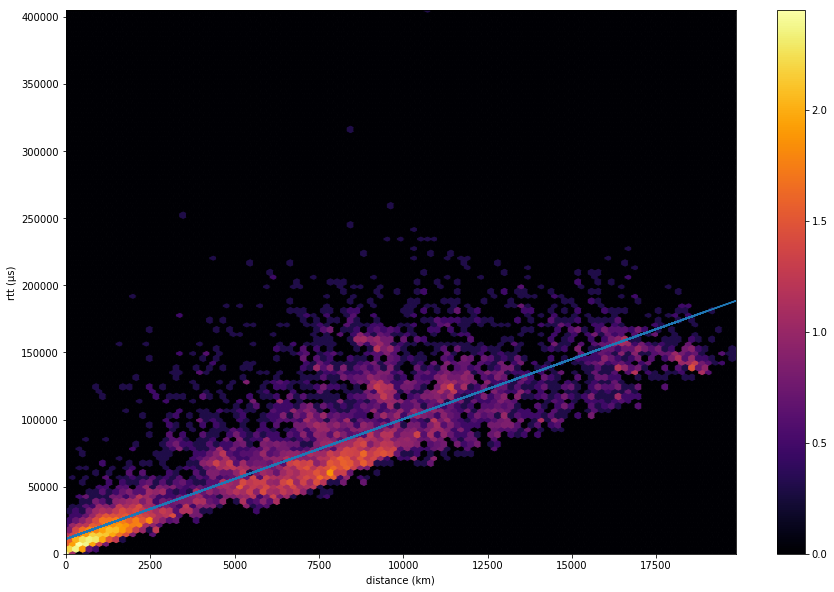

In [17]:
plt.figure(figsize=(15,10))

plot_df = min_df

x = plot_df['km']
y = plot_df['minrtt'] / 2
plt.hexbin(x, y, cmap="inferno", bins="log")
plt.colorbar()
plt.xlabel("distance (km)")
plt.ylabel("rtt (µs)")

(m, b, r, p, e) = scipy.stats.linregress(plot_df['km'],plot_df['minrtt']/2)
print("slope = {}, rvalue = {}".format(m, r))
plt.plot(x, m * x + b)

This is a better R-value than we'd expect, actually. Is the correlation dependent on RTT, distance, or anchor? First, RTT bins:

In [46]:
300/4

75.0

In [43]:
BINSKIP = 4000
BINMAX = 300000

rtt_bin = [0, BINSKIP]
km_sets = []

while rtt_bin[1] <= BINMAX:
    sub_df = min_df[(min_df['minrtt'] >= rtt_bin[0]) & (min_df['minrtt'] < rtt_bin[1])]
    (m, b, r, p, e) = scipy.stats.linregress(sub_df['km'],sub_df['minrtt']/2)
    print ("Between {} and {} µs, slope is {}, rvalue is {}".format(rtt_bin[0], rtt_bin[1], m, r))
    km_sets.append(sub_df['km'])
    rtt_bin[0] += BINSKIP
    rtt_bin[1] += BINSKIP

    

Between 0 and 4000 µs, slope is 3.4589101569243383, rvalue is 0.31547151605689655
Between 4000 and 8000 µs, slope is 1.8948826513296375, rvalue is 0.46238473239419103
Between 8000 and 12000 µs, slope is 1.1921521527512622, rvalue is 0.306063839538239
Between 12000 and 16000 µs, slope is 0.3767061212871335, rvalue is 0.13238803889650186
Between 16000 and 20000 µs, slope is 0.4050427041441138, rvalue is 0.16860813518034196
Between 20000 and 24000 µs, slope is 0.2703198136632734, rvalue is 0.14125489432082253
Between 24000 and 28000 µs, slope is 0.3682078136191895, rvalue is 0.23915324813377573
Between 28000 and 32000 µs, slope is 0.22485750069291052, rvalue is 0.16490800124443064
Between 32000 and 36000 µs, slope is 0.12426651802068604, rvalue is 0.11055617284759688
Between 36000 and 40000 µs, slope is 0.11997337451344173, rvalue is 0.1117737270778398
Between 40000 and 44000 µs, slope is 0.034032154200068075, rvalue is 0.03069397248280004
Between 44000 and 48000 µs, slope is 0.0762803560

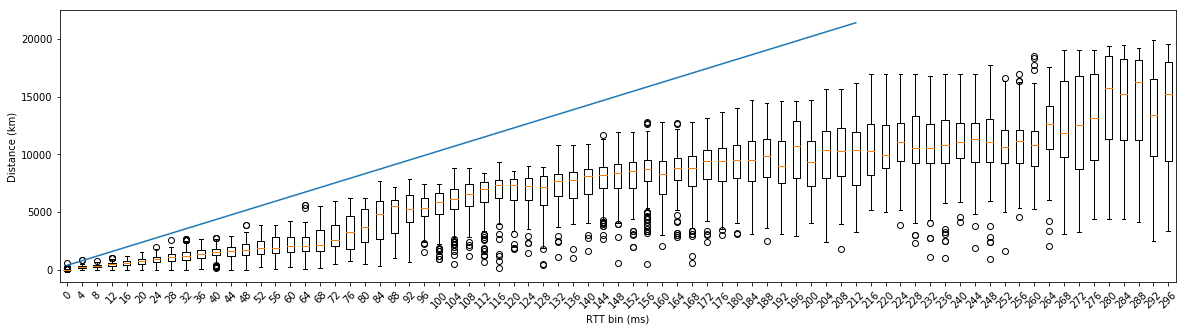

In [71]:
plt.figure(figsize=(20,5))
plt.boxplot(km_sets)
plt.xlabel("RTT bin (ms)")
plt.xticks(np.arange(1,76), np.arange(0, 300, 4), rotation=45)
plt.ylabel("Distance (km)")
plt.plot(np.arange(1,55), np.arange(1,55) * 4 * 300 * 0.33)

## Next steps

- Show RTTs for each distance bin and distances for each RTT bin as boxplots
- Generate most likely distance for each RTT bin (in ms?)?
- Attempt actual 3D trilateration (see https://gis.stackexchange.com/questions/66/trilateration-using-3-latitude-and-longitude-points-and-3-distances) and generalize to n-lateration, calculate errors. 

### Trilateration